### Current Issue 7/10
1. Get more dataset of mental state and validate with 1246_gru_tested.h5
2. Move onto real-time classification with the fully trained model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random

from sklearn.model_selection import train_test_split

## Feature extraction method
from scipy import signal
from sklearn.decomposition import FastICA, PCA

## Dataset
Using a person's 3 different mental states, relaxed, neutral, concetrating<br>
- Sampling rate: 256 Hz (256 samples in 1 second period) 
- `trials = 3, channels = 4, samples = 15204 * 0.75, kernels = 1`

### Demo 1, using the whole dataset

In [2]:
sub_a_relaxed = pd.read_csv(os.getcwd() + '/dataset/original_data/subjecta-relaxed-1.csv')
print('sub_a_relaxed shape: {}'.format(sub_a_relaxed.shape))

sub_a_neutral = pd.read_csv(os.getcwd() + '/dataset/original_data/subjecta-neutral-1.csv')
print('sub_a_neutral shape: {}'.format(sub_a_neutral.shape))

sub_a_concentrating = pd.read_csv(os.getcwd() + '/dataset/original_data/subjecta-concentrating-1.csv')
print('sub_a_concentrating shape: {}'.format(sub_a_concentrating.shape))

sub_a_relaxed shape: (15204, 6)
sub_a_neutral shape: (15204, 6)
sub_a_concentrating shape: (15192, 6)


#### Data Cleaning
- Drop unnecessary columns = `['timestamps','Right AUX']`
- Match the number of samples = `15192`

In [29]:
sub_a_relaxed = sub_a_relaxed.drop(columns=['timestamps','Right AUX'])
sub_a_neutral = sub_a_neutral.drop(columns=['timestamps','Right AUX'])
sub_a_concentrating = sub_a_concentrating.drop(columns=['timestamps','Right AUX'])

In [15]:
sub_a_relaxed = sub_a_relaxed[:15192]
sub_a_neutral = sub_a_neutral[:15192]

print('sub_a_relaxed\' shape: {}'.format(sub_a_relaxed.shape))
print('sub_a_neutral\' shape: {}'.format(sub_a_neutral.shape))
print('sub_a_concentrating\' shape: {}'.format(sub_a_concentrating.shape))

sub_a_relaxed' shape: (15192, 4)
sub_a_neutral' shape: (15192, 4)
sub_a_concentrating' shape: (15192, 4)


#### Preprocessing
- Convert data to NHWC (trials, channels, samples, kernels) format

In [24]:
X = np.array([np.transpose(sub_a_relaxed), np.transpose(sub_a_neutral), np.transpose(sub_a_concentrating)])
print(X.shape)
X

(3, 4, 15192)


array([[[ 30.762,  26.367,  21.484, ...,  21.484,  20.996,  33.203],
        [ 15.625,  13.672,  14.16 , ...,  22.949,  21.973,  22.461],
        [ 29.785,  28.32 ,  28.32 , ...,  34.18 ,  33.691,  31.738],
        [  0.977,   0.   ,   2.93 , ...,  11.23 ,   5.859,  10.254]],

       [[  4.883,  19.531,  20.508, ...,  34.668,  35.156,  20.02 ],
        [ 22.949,  22.461,  19.531, ...,  33.203,  32.715,  30.273],
        [  8.789,   5.371,  11.23 , ...,  16.602,  18.555,  10.254],
        [ 23.926,  28.32 ,  25.391, ...,  25.391,  35.156,  18.555]],

       [[ 59.105,  62.012,  44.922, ...,  48.828,  50.293,  45.41 ],
        [ 28.32 ,  30.273,  30.273, ...,  31.25 ,  31.25 ,  30.273],
        [ 15.137,  43.945, -97.656, ..., 258.789, 264.16 ,  27.344],
        [ 12.207,  11.719,  11.23 , ...,  38.086,  39.551,  39.062]]])

#### Label
- 0.0 = relaxed<br>
- 1.0 = neutral<br>
- 2.0 = concetrating

In [9]:
labels

array([2, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 0, 2, 1, 2, 1, 1, 0, 0, 1,
       0, 0])

In [28]:
Y = np.array([0.0, 1.0, 2.0])
print(Y.shape)
Y

(3,)


array([0., 1., 2.])

### First Demo with 15192 samples (1 min period of mental state)

In [78]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
model  = EEGNet(nb_classes=3, Chans=4, Samples=X.shape[2],
                dropoutRate = 0.5, kernLength=int(X.shape[2]/2), 
                F1=8, D=2, F2=16, dropoutType = 'Dropout')
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4, 15192, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 15192, 8)       60768     
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 15192, 8)       32        
_________________________________________________________________
depthwise_conv2d_4 (Depthwis (None, 1, 15192, 16)      64        
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 15192, 16)      64        
_________________________________________________________________
activation_8 (Activation)    (None, 1, 15192, 16)      0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 1, 3798, 16)       0   

In [64]:
X_train = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X_train.shape

(3, 4, 15192, 1)

In [79]:
model.fit(X_train, Y_train, batch_size = 128, epochs=5)

Epoch 1/5
1/1 [==============================] - 9s 9s/step - loss: 1.2772 - accuracy: 0.6667
Epoch 2/5
1/1 [==============================] - 8s 8s/step - loss: 0.7128 - accuracy: 1.0000
Epoch 3/5
1/1 [==============================] - 8s 8s/step - loss: 0.2945 - accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 8s 8s/step - loss: 0.1381 - accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 9s 9s/step - loss: 0.0612 - accuracy: 1.0000


In [94]:
# Using as a test dataset
sub_b_relaxed = pd.read_csv(os.getcwd() + '/dataset/original_data/subjectb-relaxed-1.csv')
sub_b_relaxed = sub_b_relaxed.drop(columns=['timestamps','Right AUX'])
sub_b_relaxed = sub_b_relaxed[:15192]
print('sub_b_relaxed shape: {}'.format(sub_b_relaxed.shape))

sub_b_relaxed shape: (15192, 4)


In [95]:
X_test = np.array([np.transpose(sub_b_relaxed)])
print(X_test.shape)
X_test

(1, 4, 15192)


array([[[ 43.457,  57.617,  41.504, ...,  17.09 ,  21.973,  47.363],
        [ 39.551,  40.039,  41.016, ...,  22.949,  30.762,  35.156],
        [ 48.828,  48.34 ,  47.852, ...,  22.949,  20.508,  27.832],
        [ 19.043,  23.438,  25.879, ..., -19.043, -20.508, -13.672]]])

In [96]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_test.shape

(1, 4, 15192, 1)

In [119]:
Y_test = np.array([0])
print(Y_test.shape)
Y_test

(1,)


array([0])

In [120]:
Y_test = np_utils.to_categorical(Y_test, num_classes=3)
print(Y_test.shape)
Y_test

(1, 3)


array([[1., 0., 0.]], dtype=float32)

In [102]:
probs = model.predict(X_test)
probs

array([[0.10493065, 0.13374467, 0.7613246 ]], dtype=float32)

In [100]:
preds = probs.argmax(axis = -1)  
preds

array([2], dtype=int64)

In [121]:
acc = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.000000 


### Demo 2, using a subset of dataset
- Matched the number of samples to 888, the df with the lowest number of rows

In [3]:
directory = os.getcwd() + '/dataset/original_data/'
files = os.listdir(directory)
random.shuffle(files)

data = []
labels = []


for filename in files:
#     if 'subject' in filename:
#         df = pd.read_csv(directory + filename)
#         df = df.drop(columns=['timestamps','Right AUX'])
#         if 'relaxed' in filename:
#             labels.append(0)
#         elif 'neutral' in filename:
#             labels.append(1)
#         elif 'concentrating' in filename:
#             labels.append(2)
#         data.append(df)
        
#         print('{}, shape = ({})'.format(filename, df.shape))
        
    if 'subject' in filename:
        df = pd.read_csv(directory + filename)
        df = df.drop(columns=['timestamps','Right AUX'])
        df = df[:888]
        if 'relaxed' in filename:
            labels.append(0)
        elif 'neutral' in filename:
            labels.append(1)
        elif 'concentrating' in filename:
            labels.append(2)
        data.append(df)
        if len(df) < 15192:
            print('{}, shape = ({})'.format(filename, df.shape))
labels = np.array(labels)

subjectb-concentrating-2.csv, shape = ((888, 4))
subjectd-neutral-1.csv, shape = ((888, 4))
subjectd-concentrating-2.csv, shape = ((888, 4))
subjectc-relaxed-1.csv, shape = ((888, 4))
subjecta-neutral-2.csv, shape = ((888, 4))
subjectd-relaxed-2.csv, shape = ((888, 4))
subjecta-concentrating-1.csv, shape = ((888, 4))
subjectb-neutral-2.csv, shape = ((888, 4))
subjectb-relaxed-2.csv, shape = ((888, 4))
subjectd-concentrating-1.csv, shape = ((888, 4))
subjectd-neutral-2.csv, shape = ((888, 4))
subjectc-relaxed-2.csv, shape = ((888, 4))
subjectb-concentrating-1.csv, shape = ((888, 4))
subjectc-concentrating-2.csv, shape = ((888, 4))
subjectb-neutral-1.csv, shape = ((888, 4))
subjecta-relaxed-2.csv, shape = ((888, 4))
subjectb-relaxed-1.csv, shape = ((888, 4))
subjecta-concentrating-2.csv, shape = ((888, 4))
subjectc-neutral-2.csv, shape = ((888, 4))
subjecta-neutral-1.csv, shape = ((888, 4))
subjectd-relaxed-1.csv, shape = ((888, 4))
subjectc-neutral-1.csv, shape = ((888, 4))
subjecta-rel

#### Preprocessing
- Convert data to NHWC (trials, channels, samples, kernels) format

In [8]:
data = np.array([np.transpose(df) for df in data])
print(data.shape)
data

(24, 4, 888)


array([[[  -6.348,  -12.207,    1.953, ...,   -2.441,   -2.93 ,
          -11.719],
        [  51.758,   55.664,   49.805, ...,   25.879,   26.855,
           26.367],
        [ -24.414,  -65.918,   61.523, ...,   73.242, -105.957,
         -112.305],
        [   4.395,    3.906,    8.789, ...,   -5.859,   -5.371,
           -5.859]],

       [[  40.527,   39.062,   29.297, ...,   59.57 ,   54.688,
           38.574],
        [  39.062,   33.691,   35.645, ...,   41.016,   39.062,
           36.133],
        [  10.742,    1.465,   -2.93 , ...,   50.293,   33.203,
           19.531],
        [  31.738,   36.133,   31.25 , ...,   41.504,   46.387,
           35.645]],

       [[  20.508,   -1.465,   -0.977, ...,   17.09 ,   19.531,
           -0.488],
        [  12.207,   15.625,   15.625, ...,   16.602,   16.602,
           11.719],
        [  25.391,   35.156,   36.133, ...,   15.625,   17.578,
           13.184],
        [  11.23 ,   -0.488,    4.883, ...,    5.371,   10.742,
        

#### Label
- 0.0 = relaxed<br>
- 1.0 = neutral<br>
- 2.0 = concetrating

In [9]:
labels

array([2, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 0, 2, 1, 2, 1, 1, 0, 0, 1,
       0, 0])

In [28]:
Y = np.array([0.0, 1.0, 2.0])
print(Y.shape)
Y

(3,)


array([0., 1., 2.])

In [4]:
kernels, chans, samples = 1, 4, 888

In [5]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
model  = EEGNet(nb_classes=3, Chans=chans, Samples=samples,
                dropoutRate = 0.5, kernLength=int(samples/2), 
                F1=8, D=2, F2=16, dropoutType = 'Dropout')
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 888, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 888, 8)         3552      
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 888, 8)         32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 888, 16)        64        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 888, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 888, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 222, 16)        0     

In [10]:
X_train = data[:18]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print('X_train.shape = {}'.format(X_train.shape))

X_test = data[18:21]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('X_test.shape = {}'.format(X_test.shape))

X_val = data[21:24]
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
print('X_val.shape = {}'.format(X_val.shape))

X_train.shape = (18, 4, 888, 1)
X_test.shape = (3, 4, 888, 1)
X_val.shape = (3, 4, 888, 1)


In [11]:
labels

array([2, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 0, 2, 1, 2, 1, 1, 0, 0, 1,
       0, 0])

In [12]:
from tensorflow.keras import utils as np_utils
Y_train = labels[:18]
Y_train = np_utils.to_categorical(Y_train, num_classes=3)
print('Y_train.shape = {}'.format(Y_train.shape))


Y_test = labels[18:21]
Y_test = np_utils.to_categorical(Y_test, num_classes=3)
print('Y_test.shape = {}'.format(Y_test.shape))

Y_val = labels[21:24]
Y_val = np_utils.to_categorical(Y_val, num_classes=3)
print('Y_val.shape = {}'.format(Y_val.shape))

Y_train.shape = (18, 3)
Y_test.shape = (3, 3)
Y_val.shape = (3, 3)


In [13]:
model.fit(X_train, Y_train, batch_size = 16, epochs=100,
         verbose = 2, validation_data=(X_val, Y_val))

Epoch 1/100
2/2 - 4s - loss: 1.6711 - accuracy: 0.4444 - val_loss: 1.1448 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 - 0s - loss: 1.0666 - accuracy: 0.3333 - val_loss: 1.1340 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 - 0s - loss: 1.0026 - accuracy: 0.5556 - val_loss: 1.1328 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 - 0s - loss: 0.9637 - accuracy: 0.5000 - val_loss: 1.1355 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 - 0s - loss: 0.9671 - accuracy: 0.4444 - val_loss: 1.1349 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 - 0s - loss: 0.9488 - accuracy: 0.6111 - val_loss: 1.1358 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 - 0s - loss: 0.9182 - accuracy: 0.6667 - val_loss: 1.1316 - val_accuracy: 0.0000e+00
Epoch 8/100
2/2 - 0s - loss: 0.8342 - accuracy: 0.7222 - val_loss: 1.1272 - val_accuracy: 0.3333
Epoch 9/100
2/2 - 0s - loss: 0.8892 - accuracy: 0.6667 - val_loss: 1.1221 - val_accuracy: 0.3333
Epoch 10/100
2/2 - 0s - loss: 0.8694 - accuracy: 0.6667 - val_loss: 1.1178 - val_accuracy: 0.3333
E

Epoch 85/100
2/2 - 0s - loss: 0.3467 - accuracy: 1.0000 - val_loss: 1.1475 - val_accuracy: 0.3333
Epoch 86/100
2/2 - 0s - loss: 0.3438 - accuracy: 1.0000 - val_loss: 1.1473 - val_accuracy: 0.3333
Epoch 87/100
2/2 - 0s - loss: 0.3564 - accuracy: 1.0000 - val_loss: 1.1415 - val_accuracy: 0.3333
Epoch 88/100
2/2 - 0s - loss: 0.3406 - accuracy: 1.0000 - val_loss: 1.1252 - val_accuracy: 0.3333
Epoch 89/100
2/2 - 0s - loss: 0.3453 - accuracy: 1.0000 - val_loss: 1.1208 - val_accuracy: 0.3333
Epoch 90/100
2/2 - 0s - loss: 0.3502 - accuracy: 1.0000 - val_loss: 1.1319 - val_accuracy: 0.3333
Epoch 91/100
2/2 - 0s - loss: 0.3779 - accuracy: 1.0000 - val_loss: 1.1503 - val_accuracy: 0.3333
Epoch 92/100
2/2 - 0s - loss: 0.3296 - accuracy: 1.0000 - val_loss: 1.1588 - val_accuracy: 0.3333
Epoch 93/100
2/2 - 0s - loss: 0.3706 - accuracy: 0.9444 - val_loss: 1.1587 - val_accuracy: 0.3333
Epoch 94/100
2/2 - 0s - loss: 0.3619 - accuracy: 1.0000 - val_loss: 1.1377 - val_accuracy: 0.3333
Epoch 95/100
2/2 - 0

In [16]:
probs       = model.predict(X_val)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_val.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.333333 


### Feature Extraction - Denoising
Fast Fourier Transform (FFT) - A method to remove the artifact from the recorded data, such as eye blinks

[ 0.00000000e+00  6.57721652e-05  1.31544330e-04 ... -1.97316496e-04
 -1.31544330e-04 -6.57721652e-05]


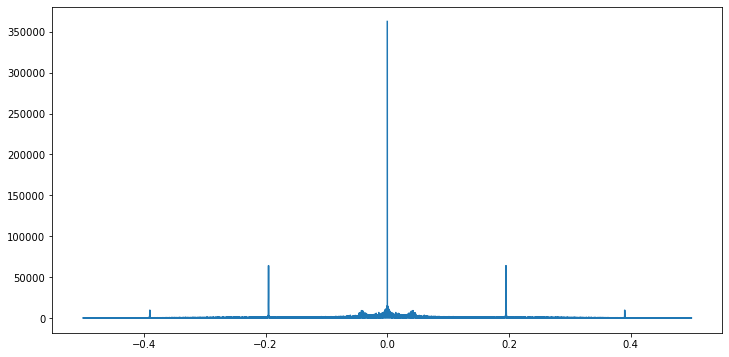

In [3]:
import numpy.fft as fft
n = sub_a_relaxed.shape[0]
spectrum = fft.fft(sub_a_relaxed['TP9'], n)
freq = fft.fftfreq(len(spectrum))
print(freq)
plt.figure(figsize=(12,6))
plt.plot(freq, abs(spectrum))

### Frequency Bands Exploration

In [6]:
data = np.loadtxt('data.txt')
data

array([-31.14010682, -29.30774113, -27.70228296, ...,  29.30581425,
        28.57226907,  22.61510519])

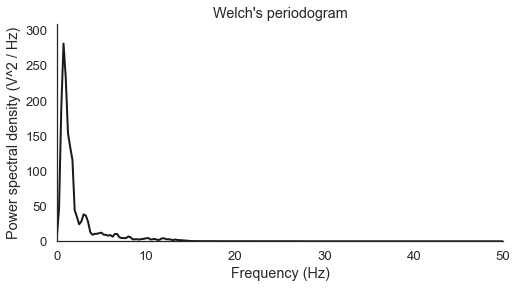

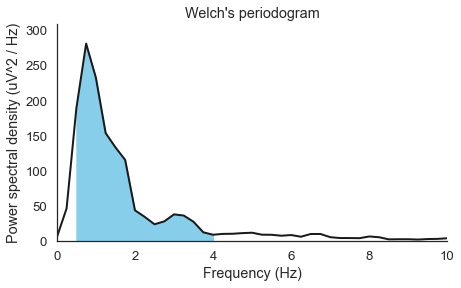

In [30]:
from scipy import signal
import seaborn as sns

sns.set(font_scale=1.2)

sf = 100.
time = np.arange(data.size) / sf

# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(data, sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [28]:
sub_a_relaxed = pd.read_csv(os.getcwd() + '/dataset/original_data/subjecta-relaxed-1.csv')

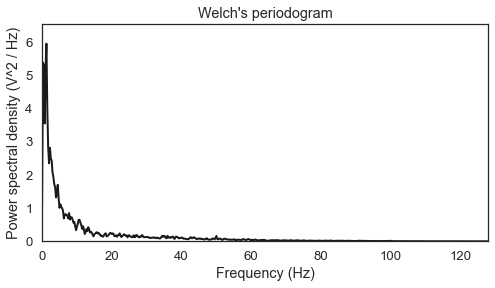

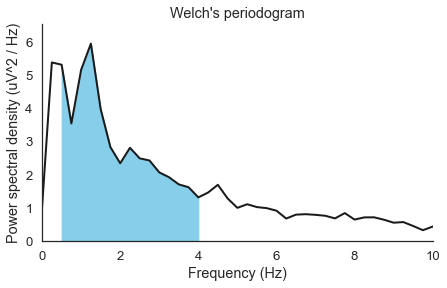

In [29]:
sf = 256.

win = 4 * sf
freqs, psd = signal.welch(sub_a_relaxed['AF7'], sf, nperseg=win)

sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()
sns.despine()

### Third Demo
Using the feature extracted dataset (989 cols)

In [38]:
mental_state = pd.read_csv("mental-state.csv")

print('mental_state shape: {}'.format(mental_state.shape))
mental_state

mental_state shape: (2479, 989)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,...,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,25.781648,33.836367,-92.769629,19.187957,-1.542262,0.197462,-119.561133,2.032654,21.596272,33.965587,...,0.000230,0.000351,0.000547,0.000381,0.000350,0.000453,0.000442,0.000325,0.000209,2.0
1,29.357891,26.792566,417.203910,19.472121,-38.797263,-16.897194,-29.368531,-9.055370,44.647424,40.893307,...,0.001671,0.000740,0.001122,0.000521,0.000624,0.000439,0.001249,0.000727,0.000801,2.0
2,28.451926,31.076434,72.231301,14.245938,-13.225057,-0.614138,-28.331698,-8.858742,31.450289,30.692883,...,0.000748,0.000569,0.000327,0.000197,0.000833,0.000909,0.000699,0.001165,0.000616,2.0
3,21.282184,19.985184,16.220094,39.787312,1.847866,0.670216,-1.820355,20.220724,21.404679,20.777411,...,0.000990,0.005644,0.006891,0.010546,0.009583,0.011158,0.008853,0.004551,0.002287,1.0
4,20.431516,28.982168,27.540246,19.960398,2.491458,-6.020503,-1.071166,2.655259,16.295039,32.658163,...,0.001659,0.014379,0.014492,0.002949,0.004575,0.008305,0.007202,0.006957,0.009836,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474,15.762328,19.113555,23.696867,7.568395,-6.503336,6.867187,-11.955396,-16.519912,19.838319,14.333094,...,0.008537,0.008941,0.004102,0.003156,0.003659,0.010179,0.004591,0.013817,0.004536,0.0
2475,34.675582,34.200645,-57.624820,-4.825609,7.382353,2.324416,-1.341208,-4.178625,26.383597,28.782987,...,0.003324,0.003593,0.001702,0.003121,0.002686,0.001645,0.001770,0.001038,0.001973,2.0
2476,29.813809,29.623031,-86.503988,7.532121,-19.581287,-0.628400,133.947160,-2.049096,45.484851,32.163999,...,0.000754,0.000508,0.000263,0.000701,0.000797,0.001096,0.000388,0.000529,0.001079,2.0
2477,59.453973,17.944332,-10.164238,42.568211,-1.300655,-19.993690,-54.331696,12.947622,55.203380,40.228490,...,0.003332,0.003557,0.004063,0.001662,0.002665,0.002353,0.003976,0.001660,0.003229,2.0


In [39]:
mental_state['Label'].value_counts()

1.0    830
2.0    830
0.0    819
Name: Label, dtype: int64

In [40]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = preprocess_inputs(mental_state)

In [42]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


model_989 = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1245)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1245, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 1245, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 318720)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 956163    
Total params: 1,155,075
Trainable params: 1,155,075
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
model_989.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model_989.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
44/44 [==============================] - 197s 4s/step - loss: 5.3855 - accuracy: 0.6119 - val_loss: 0.8193 - val_accuracy: 0.8444
Epoch 2/20
44/44 [==============================] - 197s 4s/step - loss: 0.5102 - accuracy: 0.8887 - val_loss: 0.5470 - val_accuracy: 0.8905
Epoch 3/20
44/44 [==============================] - 198s 5s/step - loss: 0.1434 - accuracy: 0.9469 - val_loss: 0.4480 - val_accuracy: 0.9193
Epoch 4/20
44/44 [==============================] - 192s 4s/step - loss: 0.1646 - accuracy: 0.9464 - val_loss: 0.6178 - val_accuracy: 0.9078
Epoch 5/20
44/44 [==============================] - 196s 4s/step - loss: 0.0668 - accuracy: 0.9742 - val_loss: 0.4044 - val_accuracy: 0.9280
Epoch 6/20
44/44 [==============================] - 171s 4s/step - loss: 0.0332 - accuracy: 0.9860 - val_loss: 0.4706 - val_accuracy: 0.9164
Epoch 7/20
44/44 [==============================] - 157s 4s/step - loss: 0.0365 - accuracy: 0.9859 - val_loss: 0.6989 - val_accuracy: 0.8761
Epoch 8/20
44

In [44]:
model_acc = model_989.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 94.758%


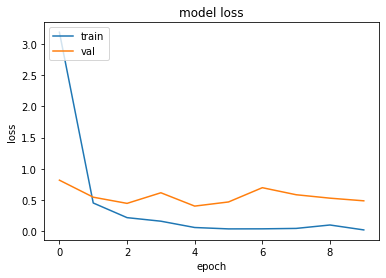

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

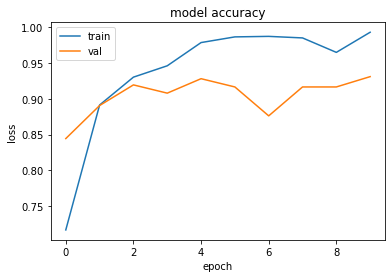

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

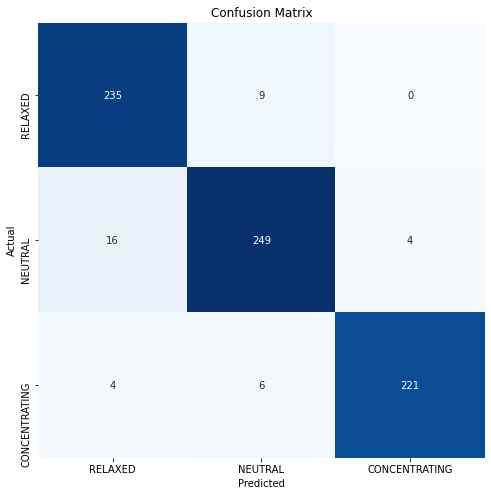

Classification Report:
----------------------
                precision    recall  f1-score   support

      RELAXED       0.92      0.96      0.94       244
      NEUTRAL       0.94      0.93      0.93       269
CONCENTRATING       0.98      0.96      0.97       231

     accuracy                           0.95       744
    macro avg       0.95      0.95      0.95       744
 weighted avg       0.95      0.95      0.95       744



In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

label_mapping = {'RELAXED': 0, 'NEUTRAL': 1, 'CONCENTRATING': 2}
y_pred = np.array(list(map(lambda x: np.argmax(x), model_989.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [52]:
model_989.save('989_gru.h5')

### Trying to find what columns to remove from 1246 (257 columns)

In [57]:
df_1246 = pd.read_csv(os.getcwd() + '/final_dataset/mental-state-1246.csv')
df_989 = pd.read_csv(os.getcwd() + '/final_dataset/mental-state-989.csv')

In [58]:
print(df_1246.shape)
df_1246

(2479, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,16.481383,15.838645,20.923613,3.868094,17.375938,1.753072,2.773070,1.560500,15.067953,-2.449311,...,0.085100,0.064925,0.031733,0.050842,0.074206,0.124876,0.018076,0.060481,0.057522,0.0
1,23.733152,28.509188,27.360910,-9.843813,25.695789,0.575784,4.896850,-12.705741,3.139401,3.876334,...,0.030827,0.041627,0.038336,0.013650,0.023462,0.047628,0.043392,0.064315,0.024526,0.0
2,21.083816,19.895562,18.968566,20.132062,24.353063,8.458956,-6.960552,8.420081,13.663810,2.692684,...,0.053886,0.036274,0.035740,0.038103,0.049851,0.015408,0.060786,0.064373,0.020419,1.0
3,3.253930,25.844574,79.116809,8.342746,20.599352,-2.702003,-0.594606,-38.274286,-2.628310,-5.524813,...,0.036960,0.046494,0.057281,0.058323,0.043862,0.053333,0.087944,0.013122,0.033914,0.0
4,32.979984,35.343152,-129.270523,25.274320,21.945969,4.657734,2.249219,-69.488195,-0.203635,-0.735726,...,0.005689,0.005457,0.001655,0.005883,0.004656,0.004733,0.004073,0.005072,0.005622,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474,24.408328,25.667238,30.307758,24.299613,22.199598,0.946822,-2.385283,-5.065522,-2.195507,4.632400,...,0.060562,0.050219,0.028050,0.037710,0.058077,0.046329,0.034661,0.073741,0.079413,0.0
2475,24.288141,21.467258,29.664977,12.277609,26.782973,-2.271717,2.137290,-2.571791,0.258334,3.943137,...,0.110801,0.048037,0.030653,0.051616,0.046190,0.051400,0.040910,0.025646,0.032765,0.0
2476,16.386016,25.449730,27.654664,10.263465,26.906937,-11.676210,3.265842,-1.749670,-15.211361,0.561848,...,0.060503,0.056769,0.016124,0.029197,0.031900,0.073301,0.015888,0.002436,0.035329,1.0
2477,22.987340,24.354957,24.288199,17.356859,24.240461,-0.552771,3.836906,37.554667,-1.576095,-4.530965,...,0.049001,0.083742,0.012564,0.034685,0.037678,0.022842,0.018358,0.011174,0.042973,0.0


In [59]:
print(df_989.shape)
df_989

(2479, 989)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,...,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,25.781648,33.836367,-92.769629,19.187957,-1.542262,0.197462,-119.561133,2.032654,21.596272,33.965587,...,0.000230,0.000351,0.000547,0.000381,0.000350,0.000453,0.000442,0.000325,0.000209,2.0
1,29.357891,26.792566,417.203910,19.472121,-38.797263,-16.897194,-29.368531,-9.055370,44.647424,40.893307,...,0.001671,0.000740,0.001122,0.000521,0.000624,0.000439,0.001249,0.000727,0.000801,2.0
2,28.451926,31.076434,72.231301,14.245938,-13.225057,-0.614138,-28.331698,-8.858742,31.450289,30.692883,...,0.000748,0.000569,0.000327,0.000197,0.000833,0.000909,0.000699,0.001165,0.000616,2.0
3,21.282184,19.985184,16.220094,39.787312,1.847866,0.670216,-1.820355,20.220724,21.404679,20.777411,...,0.000990,0.005644,0.006891,0.010546,0.009583,0.011158,0.008853,0.004551,0.002287,1.0
4,20.431516,28.982168,27.540246,19.960398,2.491458,-6.020503,-1.071166,2.655259,16.295039,32.658163,...,0.001659,0.014379,0.014492,0.002949,0.004575,0.008305,0.007202,0.006957,0.009836,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474,15.762328,19.113555,23.696867,7.568395,-6.503336,6.867187,-11.955396,-16.519912,19.838319,14.333094,...,0.008537,0.008941,0.004102,0.003156,0.003659,0.010179,0.004591,0.013817,0.004536,0.0
2475,34.675582,34.200645,-57.624820,-4.825609,7.382353,2.324416,-1.341208,-4.178625,26.383597,28.782987,...,0.003324,0.003593,0.001702,0.003121,0.002686,0.001645,0.001770,0.001038,0.001973,2.0
2476,29.813809,29.623031,-86.503988,7.532121,-19.581287,-0.628400,133.947160,-2.049096,45.484851,32.163999,...,0.000754,0.000508,0.000263,0.000701,0.000797,0.001096,0.000388,0.000529,0.001079,2.0
2477,59.453973,17.944332,-10.164238,42.568211,-1.300655,-19.993690,-54.331696,12.947622,55.203380,40.228490,...,0.003332,0.003557,0.004063,0.001662,0.002665,0.002353,0.003976,0.001660,0.003229,2.0


In [79]:
c = list(set(df_1246.columns).symmetric_difference(df_989.columns))
c

['freq_172_4',
 'freq_689_4',
 'lag1_freq_476_4',
 'mean_d_h2h1_4',
 'topFreq_6_4',
 'std_d_h2h1_4',
 'lag1_topFreq_2_4',
 'lag1_freq_730_4',
 'lag1_freq_111_4',
 'lag1_mean_d_q2q3_4',
 'lag1_freq_182_4',
 'max_4',
 'freq_568_4',
 'lag1_eigenval_4',
 'topFreq_1_4',
 'lag1_freq_345_4',
 'lag1_freq_172_4',
 'lag1_freq_395_4',
 'lag1_freq_720_4',
 'max_d_q1q2_4',
 'lag1_freq_456_4',
 'logcovM_3_4',
 'lag1_covM_0_4',
 'freq_203_4',
 'lag1_topFreq_10_4',
 'lag1_freq_416_4',
 'covM_0_4',
 'lag1_covM_1_4',
 'lag1_topFreq_3_4',
 'lag1_std_4',
 'topFreq_8_4',
 'min_d_q3q4_4',
 'topFreq_10_4',
 'freq_679_4',
 'kurt_4',
 'mean_d_q1q2_4',
 'lag1_topFreq_4_4',
 'freq_314_4',
 'lag1_freq_689_4',
 'freq_213_4',
 'max_q3_4',
 'lag1_freq_233_4',
 'lag1_logcovM_4_4',
 'lag1_max_d_q1q3_4',
 'lag1_kurt_4',
 'lag1_freq_324_4',
 'freq_486_4',
 'mean_4',
 'lag1_skew_4',
 'freq_041_4',
 'lag1_topFreq_8_4',
 'max_d_q2q4_4',
 'lag1_freq_628_4',
 'max_d_q1q3_4',
 'freq_456_4',
 'lag1_freq_223_4',
 'lag1_freq_466

In [76]:
for col in c:
    print(df_1246.columns.get_loc(col))

1189
1238
574
609
880
669
231
597
538
39
545
684
1226
174
875
561
544
566
596
714
572
833
159
1192
239
568
804
163
232
49
882
799
884
1237
679
634
233
1203
593
1193
704
550
189
94
64
559
1220
604
59
1176
237
734
587
719
1217
549
573
1210
74
540
659
1181
535
238
530
14
1244
1223
764
579
1175
1214
144
1221
570
580
533
724
1224
4
1204
1188
595
567
1182
558
149
1222
639
554
588
560
1229
551
599
528
119
1184
689
591
569
154
576
1225
129
729
34
124
529
1208
536
1230
169
537
553
699
575
29
188
563
877
876
571
1173
1228
1232
619
589
649
9
749
1201
1241
744
774
99
664
1216
1213
565
564
709
1227
819
878
552
1215
584
1186
1195
654
808
24
883
134
1236
235
139
236
1178
1235
166
586
541
168
598
834
531
784
881
769
624
1200
824
1198
779
1240
1234
179
1174
1206
614
234
1243
1185
1205
879
54
44
814
694
1197
109
1194
1219
1231
1239
230
1177
592
1211
1212
1242
542
114
89
1179
759
555
556
1218
811
1202
581
534
532
582
69
644
1187
79
1207
578
1183
754
739
1191
828
562
104
1196
789
547
1180
674
548
84
186
5

### Classification Progress Demo
- Generating a new dataset, combine every possible dataset we have so far (1246 column datasets)

In [47]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

path = os.getcwd() + '/dataset/original_data'
print('Generating matrix from {}'.format(path))
gen_training_matrix(path, 'ultimate-mental-state.csv', [])

Generating matrix from C:\Users\14056\Desktop\EEG_Classification/dataset/original_data
name-concentrating-1
name
concentrating
Using file name-concentrating-1.csv
resulting vector shape for the file (116, 1246)
subjecta-concentrating-1
subjecta
concentrating
Using file subjecta-concentrating-1.csv
resulting vector shape for the file (116, 1246)
subjecta-concentrating-2
subjecta
concentrating
Using file subjecta-concentrating-2.csv
resulting vector shape for the file (102, 1246)
subjecta-neutral-1
subjecta
neutral
Using file subjecta-neutral-1.csv
resulting vector shape for the file (116, 1246)
subjecta-neutral-2
subjecta
neutral
Using file subjecta-neutral-2.csv
resulting vector shape for the file (117, 1246)
subjecta-relaxed-1
subjecta
relaxed
Using file subjecta-relaxed-1.csv
resulting vector shape for the file (116, 1246)
subjecta-relaxed-2
subjecta
relaxed
Using file subjecta-relaxed-2.csv
resulting vector shape for the file (116, 1246)
subjectb-concentrating-1
subjectb
concentrati

C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


resulting vector shape for the file (84, 1246)
subjecte-concentrating-2
subjecte
concentrating
Using file subjecte-concentrating-2.csv
resulting vector shape for the file (55, 1246)
subjecte-neutral-1
subjecte
neutral
Using file subjecte-neutral-1.csv


C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


resulting vector shape for the file (79, 1246)
subjecte-neutral-2
subjecte
neutral
Using file subjecte-neutral-2.csv
resulting vector shape for the file (67, 1246)
subjecte-relaxed-1
subjecte
relaxed
Using file subjecte-relaxed-1.csv
resulting vector shape for the file (79, 1246)
subjecte-relaxed-2
subjecte
relaxed
Using file subjecte-relaxed-2.csv
resulting vector shape for the file (59, 1246)
FINAL_MATRIX (2902, 1246)


In [94]:
df = pd.read_csv(os.getcwd() + '/final_dataset/ultimate-mental-state.csv')
print(df.shape)
df

(2902, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,22.893855,30.412723,26.029590,14.249789,25.440242,-7.101478,-0.551013,3.735563,-9.372750,-5.329480,...,0.080341,4.965429e-02,2.612327e-02,0.030301,3.546703e-02,0.055508,6.329772e-02,7.144508e-02,0.046547,1.0
1,21.810559,24.108879,16.599691,-8.642172,24.791711,-1.305863,-4.731962,7.459924,-0.014769,0.940731,...,0.038109,6.765979e-02,3.109398e-02,0.070536,6.194057e-02,0.042393,3.474493e-02,6.307529e-02,0.022254,0.0
2,24.278617,25.215187,15.668879,17.013527,24.446484,7.218074,-4.339539,-0.363437,8.643985,0.059869,...,0.040962,5.655849e-02,3.648760e-02,0.047142,1.717881e-02,0.054836,4.089540e-03,5.307469e-02,0.016421,0.0
3,-30.250535,-32.649992,-30.521379,-21.618551,1.000000,4.143066,1.937572,1.357539,4.399786,0.000000,...,0.000000,1.784802e-19,1.778891e-19,0.000000,8.748897e-19,0.000000,1.763288e-19,1.761353e-19,0.000000,0.0
4,25.545121,29.661176,31.894648,24.271008,27.521129,-5.001456,-1.413423,0.453609,-2.489220,-2.833442,...,0.036457,2.638348e-02,2.963056e-02,0.061503,3.736360e-02,0.038793,2.425808e-03,3.386304e-02,0.019684,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,13.708117,-337.991707,-113.306059,12.086828,23.874313,6.386891,512.648208,157.328791,7.050319,-1.243022,...,0.005520,6.885666e-03,5.299998e-03,0.006707,8.183844e-03,0.000943,1.164625e-02,2.777334e-03,0.012194,2.0
2898,23.416512,27.540238,42.179102,0.473047,29.109957,2.699743,-5.414999,-20.888921,3.923602,4.966026,...,0.096640,4.266555e-02,5.912066e-02,0.065626,4.408449e-02,0.053612,2.827642e-02,3.503184e-02,0.046586,0.0
2899,12.365332,23.424203,21.366109,5.121270,23.458484,-2.353175,-2.408318,1.432315,-1.196755,7.516107,...,0.034336,7.786022e-02,9.270427e-02,0.091345,6.086653e-02,0.059444,3.097274e-02,1.538622e-02,0.044919,0.0
2900,35.274484,24.690652,24.463645,-2.979277,19.861211,29.896946,7.296830,-16.680746,24.485432,4.279367,...,0.027575,6.029478e-02,4.728673e-02,0.029320,4.468241e-02,0.010577,3.627132e-02,3.688704e-02,0.078377,1.0


In [95]:
df['Label'].value_counts()

1.0    976
2.0    969
0.0    957
Name: Label, dtype: int64

In [96]:
from sklearn.model_selection import train_test_split

def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_inputs(df)

### Best Model so far
- `ultimate_gru.h5` is trained on the ultimate-mental-state.csv, which includes jordan's dataset + my 3 different mental states, from my-mental-state folder
- 7/14 training a model solely on my-mental state achieved `Test Accuracy: 51.444%`

Epoch 50/50
51/51 [==============================] - 127s 2s/step - loss: 1.4701e-06 - accuracy: 1.0000 - val_loss: 2.8691 - val_accuracy: 0.9165

In [93]:
model = tf.keras.models.load_model(os.getcwd() + '/saved_models/ultimate_gru.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1245)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1245, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 1245, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 318720)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 956163    
Total params: 1,155,075
Trainable params: 1,155,075
Non-trainable params: 0
_________________________________________________________________


In [86]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 92.308%


### Testing `ultimate_gru.h5` on second_trials test set

In [54]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

# Model is trained with subjecta-relaxed-1, subjecta-neutral-1, subjecta-concentrating-1, now testing with -2s
path = os.getcwd() + '/new_dataset/my-mental-state'
print(path)
gen_training_matrix(path, 'second_trials.csv', [])

C:\Users\14056\Desktop\EEG_Classification/new_dataset/my-mental-state
subjecta-concentrating-2
subjecta
concentrating
Using file subjecta-concentrating-2.csv


C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


resulting vector shape for the file (55, 1246)
subjecta-neutral-2
subjecta
neutral
Using file subjecta-neutral-2.csv
resulting vector shape for the file (67, 1246)
subjecta-relaxed-2
subjecta
relaxed
Using file subjecta-relaxed-2.csv
resulting vector shape for the file (59, 1246)
FINAL_MATRIX (181, 1246)


In [88]:
test_set = pd.read_csv(os.getcwd() + '/final_dataset/second_trials.csv')
print(test_set.shape)
test_set

(181, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,-35.860090,-32.758699,-30.435594,-6.793773,1.0,-0.296134,-0.178013,-0.684715,-4.524108,0.0,...,0.0,1.784802e-19,1.778891e-19,0.0,1.749779e-18,0.0,1.763288e-19,1.761353e-19,0.0,0.0
1,-32.087336,-33.014312,-32.142652,-15.238281,1.0,0.049073,1.424256,-3.328667,-4.123781,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0
2,-30.350516,-31.803148,-27.876715,-22.692773,1.0,-5.603047,-3.226724,0.896780,-1.460413,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.0
3,-29.253828,-29.735555,-27.010766,-27.036820,1.0,2.915368,-1.152430,2.345665,6.133561,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.0
4,-30.815145,-29.436160,-30.952469,-26.436363,1.0,1.376743,-0.298479,-3.633788,-4.928824,0.0,...,0.0,1.784802e-19,1.778891e-19,0.0,1.749779e-18,0.0,1.763288e-19,1.761353e-19,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,-31.822188,-30.979160,-29.081332,-22.063312,1.0,0.363415,3.256240,-0.713420,6.941410,0.0,...,0.0,3.569605e-19,3.557783e-19,0.0,0.000000e+00,0.0,3.526575e-19,3.522706e-19,0.0,2.0
177,-33.605555,-30.603383,-28.749461,-27.953809,1.0,-10.206706,-0.548949,-1.102485,-4.705868,0.0,...,0.0,1.784802e-19,1.778891e-19,0.0,0.000000e+00,0.0,1.763288e-19,1.761353e-19,0.0,2.0
178,-31.791680,-30.311551,-30.822770,-25.910738,1.0,0.482865,3.474233,-3.460362,-10.696377,0.0,...,0.0,1.784802e-19,1.778891e-19,0.0,0.000000e+00,0.0,1.763288e-19,1.761353e-19,0.0,2.0
179,-28.942125,-29.798512,-29.670719,-24.277250,1.0,0.242189,2.100888,0.591966,-1.561784,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,2.0


In [89]:
label_mapping = {'RELAXED': 0, 'NEUTRAL': 1, 'CONCENTRATING': 2}
test_set['Label'].value_counts()

1.0    67
0.0    59
2.0    55
Name: Label, dtype: int64

In [98]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_inputs(test_set)

In [91]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 92.727%


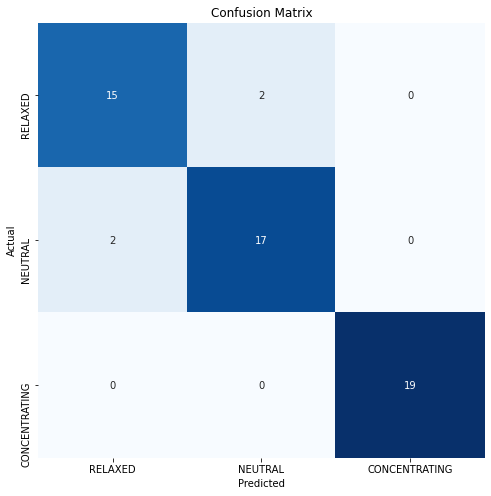

Classification Report:
----------------------
                precision    recall  f1-score   support

      RELAXED       0.88      0.88      0.88        17
      NEUTRAL       0.89      0.89      0.89        19
CONCENTRATING       1.00      1.00      1.00        19

     accuracy                           0.93        55
    macro avg       0.93      0.93      0.93        55
 weighted avg       0.93      0.93      0.93        55



In [100]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

### Testing `ultimate_gru.h5` on minecraft play dataset

- Task 1. Randomly moving or jumping around in any direction (60s)

- Task 2. Continuously building blocks of user's choice, could be a simple N x N shape (60s)

- Task 3. Simply mining with any tool user wants (60s)

### Validating over my collected data (7/10)
1. Reformat the timestamp (÷ 1,000,000) that period of 1.0 can actually represent 1 second in the timestamp of the dataset (currently 1,000,000 represents one second period)
2. Export the new dataset into my_new_data
3. Perform feature extraction over my_new_data folder

In [29]:
def reformat_timestamp_n_export(raw_dir, new_dir):
    
    # ~/new_dataset
    if not os.getcwd() + '/new_dataset':
        os.mkdir('/new_dataset')
        
    # ~/new_dataset/filename        
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
    
    files = os.listdir(raw_dir)
    for file in files:
        if '.csv' in file:
            print(file)
            df = pd.read_csv(raw_dir + '/' + file)
            for i in range(df['timestamps'].shape[0]):
                timestamp = df['timestamps'][i]/1000000.0
                df['timestamps'][i] = timestamp
            df.to_csv(new_dir + '/' + file, index=False)

In [30]:
def new_dataset(filename):
    
    new_dir = os.getcwd() + '/new_dataset/' + os.path.basename(raw_dir)
    print('Writing the outfile to \'{}\''.format(new_dir))
    
    reformat_timestamp_n_export(raw_dir, new_dir)
    
# Edit filename (from raw dataset folder) here
filename = 'my-mental-state'

new_dataset(filename)

Writing the outfile to 'C:\Users\14056\Desktop\EEG_Classification/new_dataset/left-right-commands-test'
subjecta-neutral-1.csv
subjecta-neutral-2.csv
subjecta-relaxed-1.csv
subjecta-relaxed-2.csv


In [32]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

filename = 'my-mental-state'
new_dir = os.getcwd() + '/new_dataset/' + filename

print('Generating matrix from: {}'.format(new_dir))

outfile_path = os.getcwd() + '/final_dataset/' + filename + '.csv'

gen_training_matrix(new_dir, outfile_path, [])

Generating matrix from: C:\Users\14056\Desktop\EEG_Classification/new_dataset/my-mental-state
subjecta-concentrating-1
subjecta
concentrating
Using file subjecta-concentrating-1.csv


C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


resulting vector shape for the file (84, 1246)
subjecta-concentrating-2
subjecta
concentrating
Using file subjecta-concentrating-2.csv
resulting vector shape for the file (55, 1246)
subjecta-neutral-1
subjecta
neutral
Using file subjecta-neutral-1.csv


C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


resulting vector shape for the file (79, 1246)
subjecta-neutral-2
subjecta
neutral
Using file subjecta-neutral-2.csv
resulting vector shape for the file (67, 1246)
subjecta-relaxed-1
subjecta
relaxed
Using file subjecta-relaxed-1.csv
resulting vector shape for the file (79, 1246)
subjecta-relaxed-2
subjecta
relaxed
Using file subjecta-relaxed-2.csv
resulting vector shape for the file (59, 1246)
FINAL_MATRIX (423, 1246)


### New Model (CNN)

In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(16, 16, 1)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(16, 16, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               1180160   
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)             

### Left and Right Demo
- 7/14: may need more training data

In [2]:
def reformat_timestamp_n_export(raw_dir, new_dir):
    
    # ~/new_dataset
    if not os.getcwd() + '/new_dataset':
        os.mkdir('/new_dataset')
        
    # ~/new_dataset/filename        
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
    
    files = os.listdir(raw_dir)
    for file in files:
        if '.csv' in file:
            print(file)
            df = pd.read_csv(raw_dir + '/' + file)
            for i in range(df['timestamps'].shape[0]):
                timestamp = df['timestamps'][i]/1000000.0
                df['timestamps'][i] = timestamp
            df.to_csv(new_dir + '/' + file, index=False)

In [3]:
def new_dataset(filename):
    
    raw_dir = os.getcwd() + '/raw_dataset/' + filename
    new_dir = os.getcwd() + '/new_dataset/' + os.path.basename(raw_dir)

    print(raw_dir)
    print(new_dir)
    
    reformat_timestamp_n_export(raw_dir, new_dir)
    

new_dataset('left-right-commands')

C:\Users\14056\Desktop\EEG_Classification/raw_dataset/left-right-commands
C:\Users\14056\Desktop\EEG_Classification/new_dataset/left-right-commands
subjecta-neutral-1.csv
subjecta-neutral-2.csv
subjecta-neutral-3.csv
subjecta-neutral-4.csv
subjecta-relaxed-1.csv
subjecta-relaxed-2.csv
subjecta-relaxed-3.csv
subjecta-relaxed-4.csv


In [7]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

filename = 'left-right-commands'

new_dir = os.getcwd() + '/new_dataset/' + filename

print('new_dir: {}'.format(new_dir))

outfile_path = os.getcwd() + '/final_dataset/left-right-commands.csv'

gen_training_matrix(new_dir, outfile_path, [])

new_dir: C:\Users\14056\Desktop\EEG_Classification/new_dataset/left-right-commands
subjecta-neutral-1
subjecta
neutral
Using file subjecta-neutral-1.csv


C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


resulting vector shape for the file (36, 1246)
subjecta-neutral-2
subjecta
neutral
Using file subjecta-neutral-2.csv
resulting vector shape for the file (27, 1246)
subjecta-neutral-3
subjecta
neutral
Using file subjecta-neutral-3.csv
resulting vector shape for the file (37, 1246)
subjecta-neutral-4
subjecta
neutral
Using file subjecta-neutral-4.csv
resulting vector shape for the file (27, 1246)
subjecta-relaxed-1
subjecta
relaxed
Using file subjecta-relaxed-1.csv
resulting vector shape for the file (25, 1246)
subjecta-relaxed-2
subjecta
relaxed
Using file subjecta-relaxed-2.csv
resulting vector shape for the file (28, 1246)
subjecta-relaxed-3
subjecta
relaxed
Using file subjecta-relaxed-3.csv
resulting vector shape for the file (27, 1246)
subjecta-relaxed-4
subjecta
relaxed
Using file subjecta-relaxed-4.csv
resulting vector shape for the file (34, 1246)
FINAL_MATRIX (241, 1246)


In [8]:
df = pd.read_csv(outfile_path)
print(df.shape)
df

(241, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,-31.457906,-30.981055,-31.833652,-19.327098,1.0,-0.231446,-1.185388,1.520611,3.041788,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,-30.813227,-30.223793,-32.409684,-27.732273,1.0,-1.702902,-0.707489,-0.314402,-4.929401,0.0,...,0.000000e+00,1.784802e-19,1.778891e-19,0.000000e+00,0.000000e+00,0.000000e+00,1.763288e-19,1.761353e-19,0.000000e+00,1.0
2,-29.691707,-31.871773,-30.965836,-21.820293,1.0,-2.439684,2.525205,-0.534982,3.348351,0.0,...,4.428933e-19,3.569605e-19,3.557783e-19,4.385062e-19,0.000000e+00,4.365796e-19,3.526575e-19,3.522706e-19,4.351439e-19,1.0
3,-41.259773,-42.781836,-23.645426,-16.824383,1.0,10.805844,7.373052,-0.184834,3.621097,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.748897e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
4,-30.794133,-30.057930,-29.823289,-18.792461,1.0,-1.256539,-0.504251,-1.749286,-3.490954,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,-28.553008,-30.857102,-31.024945,-24.326832,1.0,1.989263,2.475941,-1.367849,-2.637814,0.0,...,2.214467e-19,1.784802e-19,1.778891e-19,2.192531e-19,0.000000e+00,2.182898e-19,1.763288e-19,1.761353e-19,2.175720e-19,1.0
237,-29.329297,-28.133418,-31.219461,-25.101223,1.0,2.015593,1.694944,2.497096,-0.107641,0.0,...,0.000000e+00,1.784802e-19,1.778891e-19,0.000000e+00,0.000000e+00,0.000000e+00,1.763288e-19,1.761353e-19,0.000000e+00,0.0
238,-28.181059,-32.695781,-32.491676,-23.210742,1.0,1.555166,0.052040,1.348999,-0.535297,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.748897e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
239,-32.461152,-32.169336,-31.881332,-20.466867,1.0,2.355074,3.369953,-1.414278,-0.274663,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [9]:
df['Label'].value_counts()

1.0    127
0.0    114
Name: Label, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_inputs(df)

In [11]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(2, activation='softmax')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1245)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1245, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 1245, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 318720)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 637442    
Total params: 836,354
Trainable params: 836,354
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=16,
    epochs=50,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=5,
#             restore_best_weights=True
#         )
#     ]
)

Epoch 1/20
9/9 [==============================] - 19s 2s/step - loss: 6.9515 - accuracy: 0.6810 - val_loss: 9.7201 - val_accuracy: 0.4118
Epoch 2/20
9/9 [==============================] - 15s 2s/step - loss: 3.3334 - accuracy: 0.6400 - val_loss: 4.1281 - val_accuracy: 0.5882
Epoch 3/20
9/9 [==============================] - 14s 2s/step - loss: 0.7802 - accuracy: 0.8621 - val_loss: 2.5066 - val_accuracy: 0.5588
Epoch 4/20
9/9 [==============================] - 14s 2s/step - loss: 0.2021 - accuracy: 0.9387 - val_loss: 2.5601 - val_accuracy: 0.5588
Epoch 5/20
9/9 [==============================] - 14s 2s/step - loss: 0.0899 - accuracy: 0.9480 - val_loss: 2.4179 - val_accuracy: 0.5588
Epoch 6/20
9/9 [==============================] - 14s 2s/step - loss: 0.0343 - accuracy: 1.0000 - val_loss: 2.3987 - val_accuracy: 0.5294
Epoch 7/20
9/9 [==============================] - 13s 1s/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 2.4129 - val_accuracy: 0.5588
Epoch 8/20
9/9 [==================

In [15]:
# 1, 2, 3, 4 with no early stop
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 67.123%


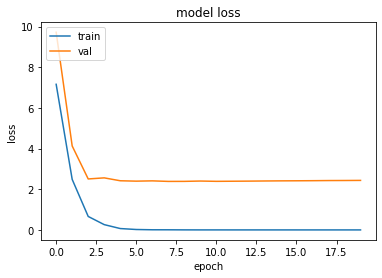

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

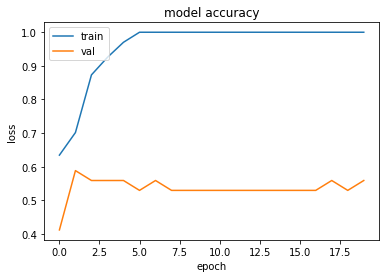

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Testing on the 5 second period dataset

In [21]:
def new_dataset(filename):
    
    raw_dir = os.getcwd() + '/raw_dataset/' + filename
    new_dir = os.getcwd() + '/new_dataset/' + os.path.basename(raw_dir)

    print(raw_dir)
    print(new_dir)
    
    reformat_timestamp_n_export(raw_dir, new_dir)
    

new_dataset('left-right-commands-test')

C:\Users\14056\Desktop\EEG_Classification/raw_dataset/left-right-commands-test
C:\Users\14056\Desktop\EEG_Classification/new_dataset/left-right-commands-test
subjecta-neutral-1.csv
subjecta-neutral-2.csv
subjecta-relaxed-1.csv
subjecta-relaxed-2.csv


In [18]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

filename = 'left-right-commands-test'
raw_dir = os.getcwd() + '/raw_dataset/' + filename
new_dir = os.getcwd() + '/new_dataset/' + os.path.basename(raw_dir)

print('new_dir: {}'.format(new_dir))

outfile_path = os.getcwd() + '/final_dataset/' + filename + '.csv'

gen_training_matrix(new_dir, outfile_path, [])

new_dir: C:\Users\14056\Desktop\EEG_Classification/new_dataset/left-right-commands-test
subjecta-neutral-1
subjecta
neutral
Using file subjecta-neutral-1.csv
resulting vector shape for the file (3, 1246)
subjecta-neutral-2
subjecta
neutral
Using file subjecta-neutral-2.csv
resulting vector shape for the file (4, 1246)
subjecta-relaxed-1
subjecta
relaxed
Using file subjecta-relaxed-1.csv


C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


resulting vector shape for the file (4, 1246)
subjecta-relaxed-2
subjecta
relaxed
Using file subjecta-relaxed-2.csv
resulting vector shape for the file (2, 1246)
FINAL_MATRIX (13, 1246)


In [19]:
df = pd.read_csv(outfile_path)
print(df.shape)
df

(13, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,-39.203629,-36.201477,-25.501270,-34.034078,1.0,-11.544008,-11.416060,6.542541,-19.546295,0.0,...,0.000000e+00,3.569605e-19,3.557783e-19,0.000000e+00,3.499559e-18,0.000000e+00,3.526575e-19,3.522706e-19,0.000000e+00,1.0
1,-31.720047,-30.111352,-27.295805,-26.313199,1.0,-0.727118,-2.904672,-6.141288,4.543294,0.0,...,0.000000e+00,3.569605e-19,3.557783e-19,0.000000e+00,1.749779e-18,0.000000e+00,3.526575e-19,3.522706e-19,0.000000e+00,0.0
2,-33.098230,-30.868543,-30.050273,-31.838281,1.0,-1.818106,1.478074,0.261959,3.405084,0.0,...,4.428933e-19,3.569605e-19,3.557783e-19,4.385062e-19,0.000000e+00,4.365796e-19,3.526575e-19,3.522706e-19,4.351439e-19,0.0
3,-29.919484,-31.583820,-27.095539,-23.610484,1.0,4.730569,-0.022249,6.329404,2.069821,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
4,-33.895465,-31.002047,-28.532047,-31.477770,1.0,1.865990,2.782137,-0.110938,2.286421,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
5,-25.871766,-31.747852,-25.160320,-23.912680,1.0,0.733614,3.989520,-3.112306,5.147156,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.749779e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
6,-18.909438,-22.560129,-34.648883,-21.023312,1.0,-15.682428,-9.118471,8.726644,-2.328777,0.0,...,0.000000e+00,8.924012e-20,8.894457e-20,0.000000e+00,0.000000e+00,0.000000e+00,8.816438e-20,8.806765e-20,0.000000e+00,1.0
7,-32.817836,-31.948090,-29.163379,-32.096859,1.0,-3.488311,-0.877012,1.462370,0.168540,0.0,...,0.000000e+00,1.784802e-19,1.778891e-19,0.000000e+00,1.749779e-18,0.000000e+00,1.763288e-19,1.761353e-19,0.000000e+00,0.0
8,-27.711855,-29.979719,-30.647262,-31.272594,1.0,33.696822,23.926246,-16.690961,23.552493,0.0,...,0.000000e+00,1.784802e-19,1.778891e-19,0.000000e+00,0.000000e+00,0.000000e+00,1.763288e-19,1.761353e-19,0.000000e+00,1.0
9,-32.823543,-30.580527,-29.386520,-32.193039,1.0,0.661964,-1.973669,-1.691101,-3.825741,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [20]:
df['Label'].value_counts()

1.0    7
0.0    6
Name: Label, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split

def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=123)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_inputs(df)

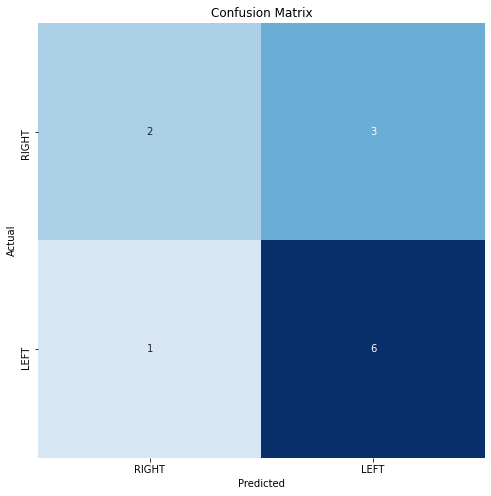

Classification Report:
----------------------
               precision    recall  f1-score   support

       RIGHT       0.67      0.40      0.50         5
        LEFT       0.67      0.86      0.75         7

    accuracy                           0.67        12
   macro avg       0.67      0.63      0.62        12
weighted avg       0.67      0.67      0.65        12



In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

label_mapping = {'RIGHT': 0, 'LEFT': 1}

y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2) + 0.5, label_mapping.keys())
plt.yticks(np.arange(2) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)